### Aplicando método de otimização para ajuste do modelo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler 

In [50]:
#import data
data = pd.read_csv("Datasets/sjc.csv")  
acc_n_cases = data.total_confirmed
normalized_acc_n_cases = data.total_confirmed / max(data.total_confirmed)
t = np.linspace(0, len(acc_n_cases), len(acc_n_cases))

# for the "one wave" tests
model = f_t
n_days = 90 

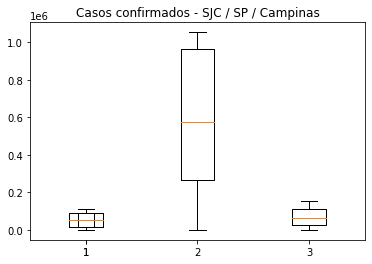

In [59]:
plt.title('Casos confirmados - SJC / SP / Campinas')
plt.boxplot(acc_n_cases)
data = pd.read_csv("Datasets/sp.csv")  
sp = data.total_confirmed
data = pd.read_csv("Datasets/campinas.csv")  
camp = data.total_confirmed
plt.boxplot([acc_n_cases, sp, camp])
plt.show()

### 1 - Uma onda epidemiológica

#### 1.1 - Definindo o problema de otimização
Definiremos uma função para descrever a perda do modelo em relação aos dados reais. Ela será a função objetivo do problema de minimização.

Seja o vetor x de parâmetros:
$$x = [A\quad \nu\quad \delta\quad t_p]^T$$
Problema de otimização descrito no artigo da ASOC:
$$min \sum_{t=0}^{t=t_{end}} t(y_t(t) - y_m(t, x))^2$$ 

$$\textrm{s.t.}\quad A \geq 0,\\\quad\quad\ \nu > 0,\\\quad\quad\ \delta > 0,\\\quad\quad\  t_p \geq 0$$ 

Ao invés de utilizarmos a função objetivo apresentada (ITSE), _utilizaremos a Mean Squared Error_ (MSE), que pode ser formulada da seguinte forma:
$$MSE(x) = \sum_{t=0}^{t=t_{end}} (y_t(t) - y_m(t, x))^2$$

A otimização será feita em duas etapas:
- 1 - Otimizar uma sigmoide simétrica ($\nu$ = 1)
- 2 - Otimizar uma sigmoide assimétrica, utilizando o ponto ótimo da etapa 1 como ponto inicial.

Para a implementação, estamos utilizando a função [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
) do pacote do otimização da biblioteca Scipy. O método de otimização utilizado é o _Sequential Least Squares Programming_ (SLSQP).

![](https://i.imgur.com/4goNTaQ.png)

A função em questão também permite a utilização de diversos outros métodos de otimização.

![](https://i.imgur.com/m2hO3lL.png)



In [23]:
n_sig = 1
sig_params = []
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_n_cases[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_n_cases[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta = 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 

/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 477.83714171857105
     jac: array([ 2.67028809e-05, -7.86590576e-03,  1.07231140e-02,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 238
     nit: 43
    njev: 43
  status: 0
 success: True
       x: array([4.38087890e+03, 1.00076094e+02, 1.39307908e+01, 1.00000000e+00])


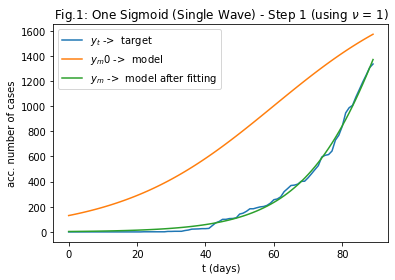

In [24]:
# Step 1 - Optimize a symmetric sigmoid (nu = 1)
y_t = acc_n_cases[:n_days]
A0 = 1.5*max(y_t)
tp0 = (2/3)*len(y_t)
delta0 = (1/4)*len(y_t)
nu0 = 1
x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.1: One Sigmoid (Single Wave) - Step 1 (using $\\nu$ = 1)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model')
plt.plot(y_m, label='$y_m$ ->  model after fitting')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()

     fun: 451.4036534614991
     jac: array([-1.40190125e-02,  9.98784256e+00, -1.52220459e+01, -4.56324757e+02])
 message: 'Iteration limit reached'
    nfev: 532
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([1.37219825e+04, 1.28364021e+02, 3.02874306e+01, 3.74061870e-01])


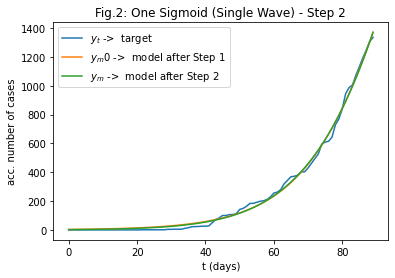

In [25]:
# Step 2 - Optimize an assymmetric sigmoid
# using optimal values of step 1 as the starting point
[A0, tp0, delta0, nu0] = sol.x

x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_t = acc_n_cases[:n_days]
y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.2: One Sigmoid (Single Wave) - Step 2')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
plt.plot(y_m, label='$y_m$ ->  model after Step 2')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()

### 2 - Múltiplas ondas epidemiológicas
Para fazer o ajuste do modelo para dados de N ondas epidemiológicas, utilizamos um modelo que envolve a soma de N sigmoides ($f(t)$).

![](https://i.imgur.com/YixfYwH.png)

[Escrever aqui um textinho mais elaborado documentando a lógica para múltiplas ondas]

In [26]:
a = []
a.append([1, 2, 3, 4])
a.append([5, 6, 7, 8])
print(a)
print(a[0])

[[1, 2, 3, 4], [5, 6, 7, 8]]
[1, 2, 3, 4]


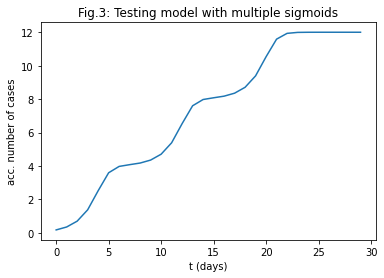

In [27]:
# Testing model for multiple sigmoids
n_days = 30
n_sig = 3
sig_params = [
    [4, 4, 0.5, 2.9],
    [4, 12, 0.5, 2.9]
]
[A, tp, delta, nu] = [4, 20, 0.5, 2.9]
plt.title('Fig.3: Testing model with multiple sigmoids')
plt.plot(model(t[:n_days], A, tp, delta, nu))
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.show()

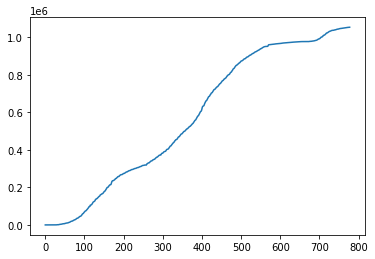

In [9]:
plt.plot(acc_n_cases)

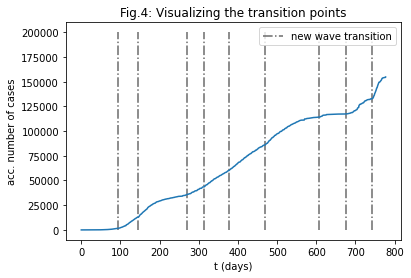

In [32]:
fig = plt.figure()
plt.plot(acc_n_cases)
# Defini manualmente, por enquanto...
# pelo new_wave.py daria x_t [11, 101, 167, 254] (Jerusalem)
# x_nw = [90, 170, 240] #(Jerusalém)
# x_nw = [147, 287, 382, 669] #(SJC)
#x_nw = [84, 259, 314, 375, 688] # (SP)
x_nw  = [94, 146, 269, 314, 377, 469, 607, 677, 741] # Campinas tr 2e-5
#x_nw = [100, 149, 471, 610, 681, 741] # Camilas tr 3e-5
plt.title('Fig.4: Visualizing the transition points')
plt.vlines(x_nw, 0, 200e3, colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()


========= Wave nr 1 =========
From 0 to  94
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 568.8357416585557
     jac: array([-6.86645508e-05,  8.07189941e-03,  2.94494629e-03,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 192
     nit: 34
    njev: 34
  status: 0
 success: True
       x: array([2.97060268e+03, 9.19813022e+01, 1.29787514e+01, 1.00000000e+00])
Step 2
     fun: 476.2269182146377
     jac: array([-0.00039291,  0.01999283,  0.01901627, -0.01403046])
 message: 'Optimization terminated successfully'
    nfev: 381
     nit: 71
    njev: 71
  status: 0
 success: True
       x: array([1607.03069554,   84.58278869,    3.46009462,    4.43957669])


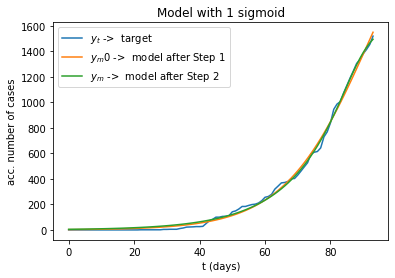

========= Wave nr 2 =========
From 0 to  146
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 18492.281307932175
     jac: array([-0.00048828, -0.0378418 ,  0.01586914,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 363
     nit: 63
    njev: 63
  status: 0
 success: True
       x: array([1.26022074e+04, 1.25547282e+02, 9.46103781e+00, 1.00000000e+00])
Step 2
     fun: 5778.211498417246
     jac: array([ 3.66210938e-04, -2.26867676e-01,  4.65209961e-01,  5.55535199e+03])
 message: 'Optimization terminated successfully'
    nfev: 145
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([1.62334153e+04, 1.25398492e+02, 1.89281095e+01, 1.00000000e-01])


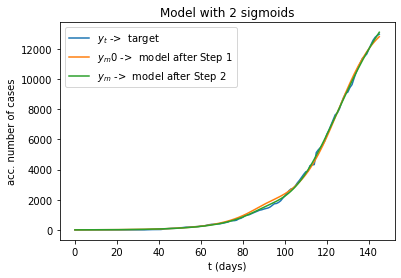

========= Wave nr 3 =========
From 0 to  269
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 326046.7184675596
     jac: array([0.        , 1.20703125, 1.48828125, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 180
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([1.59711355e+04, 1.81832055e+02, 1.60128548e+01, 1.00000000e+00])
Step 2
     fun: 326046.7184675596
     jac: array([-1.95312500e-02,  1.21484375e+00,  1.46875000e+00,  2.20219680e+05])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 5
    njev: 1
  status: 0
 success: True
       x: array([1.59711355e+04, 1.81832055e+02, 1.60128548e+01, 1.00000000e+00])


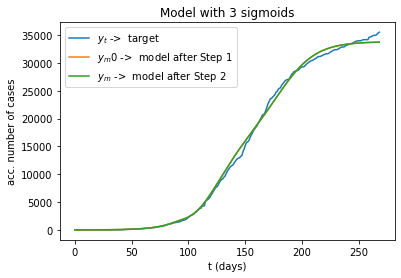

========= Wave nr 4 =========
From 0 to  314
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 236864.70775333542
     jac: array([-0.00585938,  0.3984375 ,  0.13671875,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 238
     nit: 40
    njev: 40
  status: 0
 success: True
       x: array([1.10619393e+04, 2.90812293e+02, 1.24252803e+01, 1.00000000e+00])
Step 2
     fun: 224822.70863143195
     jac: array([ 0.00000000e+00, -9.96093750e-02, -7.20703125e-01,  8.93534375e+03])
 message: 'Optimization terminated successfully'
    nfev: 149
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([1.60556239e+04, 2.94341076e+02, 2.78589046e+01, 1.00000000e-01])


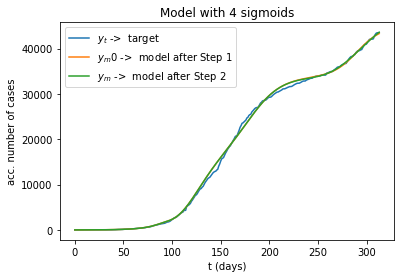

========= Wave nr 5 =========
From 0 to  377
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 220387.28321741777
     jac: array([ 0.00390625, -0.04882812, -0.10742188,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 133
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1.11775805e+04, 3.47728072e+02, 1.26516822e+01, 1.00000000e+00])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 202419.6982980243
     jac: array([ 0.00000000e+00, -1.17187500e-01,  1.75781250e-02,  1.82351133e+04])
 message: 'Optimization terminated successfully'
    nfev: 130
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([1.35663083e+04, 3.45679769e+02, 2.36422106e+01, 1.00000000e-01])


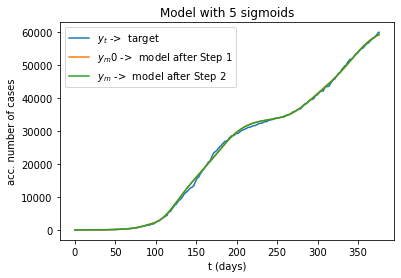

========= Wave nr 6 =========
From 0 to  469
Step 1
     fun: 275791.2580346153
     jac: array([0.00390625, 0.12109375, 0.16796875, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 127
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([2.31621740e+04, 4.23009538e+02, 1.76524846e+01, 1.00000000e+00])
Step 2
     fun: 197071.38460251127
     jac: array([7.81250000e-03, 9.51171875e-01, 8.39843750e-02, 7.33955684e+04])
 message: 'Optimization terminated successfully'
    nfev: 166
     nit: 27
    njev: 27
  status: 0
 success: True
       x: array([2.73497104e+04, 4.19029105e+02, 3.22074008e+01, 1.00000000e-01])


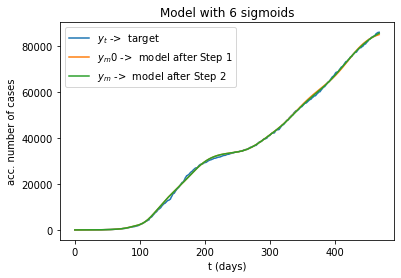

========= Wave nr 7 =========
From 0 to  607
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 327498.16991548915
     jac: array([-0.015625  , -0.37890625,  0.3671875 ,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 142
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([2.30833277e+04, 5.16512240e+02, 2.04786078e+01, 1.00000000e+00])
Step 2
     fun: 205252.4083390881
     jac: array([-1.36718750e-02, -5.97656250e-01,  4.47265625e-01,  1.03280627e+05])
 message: 'Optimization terminated successfully'
    nfev: 113
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([2.44956953e+04, 5.06863248e+02, 3.23525041e+01, 1.00000000e-01])


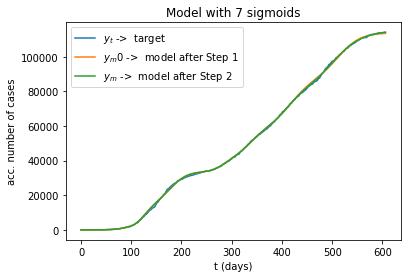

========= Wave nr 8 =========
From 0 to  677
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 570825.4333637286
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([2.68135008e+04, 2.08212467e+03, 1.67944884e-01, 1.00000000e+00])
Step 2
     fun: 570825.4333637286
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([2.68135008e+04, 2.08212467e+03, 1.67944884e-01, 1.00000000e+00])


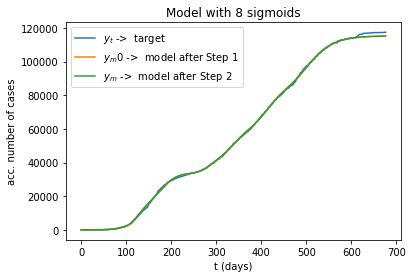

========= Wave nr 9 =========
From 0 to  741
Step 1
     fun: 10993411.151839644
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([3.21762009e+04, 2.18212467e+03, 1.67944884e-01, 1.00000000e+00])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 10993411.151839644
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([3.21762009e+04, 2.18212467e+03, 1.67944884e-01, 1.00000000e+00])


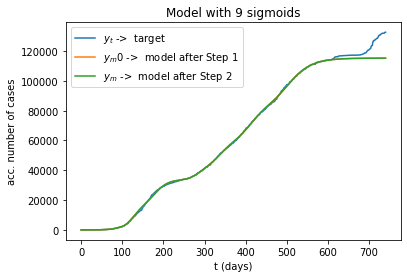

========= Wave nr 10 =========
From 0 to  778
Step 1
     fun: 57294592.376089215
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([3.86114411e+04, 2.28212467e+03, 1.67944884e-01, 1.00000000e+00])
Step 2
     fun: 57294592.376089215
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([3.86114411e+04, 2.28212467e+03, 1.67944884e-01, 1.00000000e+00])


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


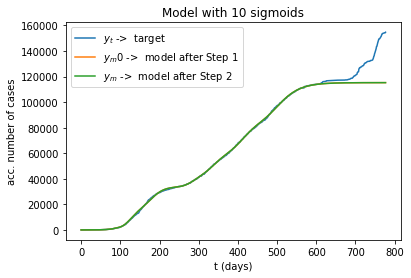

In [33]:
n_sig = 1
sig_params = []
for i in range(len(x_nw) + 1):
    if(i == len(x_nw)):
        n_days = len(acc_n_cases)
    else:
        n_days = x_nw[i]
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_n_cases[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 1.2
    # else:
    #     [A0, tp0, delta0, nu0] = sig_params[len(sig_params) - 1]
    #     tp0 = tp0 + 100
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    y_t = acc_n_cases[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"
    plt.title(f'Model with {n_sig} sigmoid{s}')
    plt.plot(y_t, label='$y_t$ ->  target')
    plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
    plt.plot(y_m, label='$y_m$ ->  model after Step 2')
    plt.xlabel('t (days)')
    plt.ylabel('acc. number of cases')
    plt.legend()
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


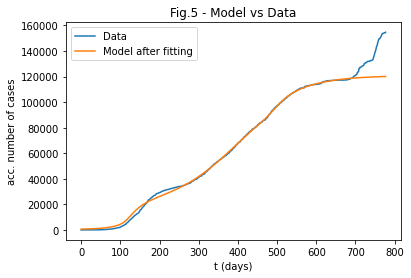

In [31]:
n_sig = 5
plt.title('Fig.5 - Model vs Data')
plt.plot(acc_n_cases[:n_days], label='Data')
plt.plot(model(t[:n_days], A, tp, delta, nu), label='Model after fitting')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()

In [13]:
n_days

778

In [ ]:
model_der = forward_euler(t[:n_days], 1, y_m[:n_days], 0)
daily_n_cases = forward_euler(t[:n_days], 1, acc_n_cases[:n_days], 0)

plt.figure(figsize=(8, 5))
plt.title('Fig.6: Model derivative x Actual data')
plt.plot(daily_n_cases, label="unfiltered data", c='silver', linestyle='dashed')
plt.plot(filter_data(daily_n_cases), label="filtered data")
plt.plot(model_der, label='model after fitting (derivative)')
plt.xlabel('t (days)')
plt.ylabel('daily number of cases')
plt.legend()
plt.show()

#### ===== Rascunho (testes para melhor entendimento) =====

In [ ]:
n_sig = 1
n_days = 90
# Initialize model parameters
A = 1500
tp = 20
delta = 3.1
nu = 2.2

y_t = acc_n_cases[:n_days]
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('One Sigmoid (Single Wave)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m, label='$y_m$ ->  model')
plt.plot(y_t - y_m, label='$y_t - y_m$')
plt.plot(abs(y_t - y_m), label='|$y_t - y_m$|')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()
plt.title('Squared Error')
plt.plot((y_t - y_m)**2, label='$(y_t - y_m)^2$')
plt.legend()
plt.show()
plt.title('Time Squared Error')
plt.plot(t[:n_days]*(y_t - y_m)**2, label='$t(y_t - y_m)^2$')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()


In [ ]:
# Fazendo testes com múltiplas ondas
# Modelo envolvendo soma de sigmoides assimétricas 
n_sig = 4
x = np.random.rand(4*n_sig)
x

In [ ]:
# Antigo... ignorar
n_sig = 4
# inicialização aleatória
x = np.random.rand(4*n_sig)
sigsum = np.zeros(n_days)
for i in range(n_sig):
    A = 1e2*x[i + 0]
    tp = 8*(i+1)
    delta = 2*x[i + 2]
    nu = 1
    sigsum += f_t(t[:n_days], A, tp, delta, nu)
plt.plot(sigsum)
plt.show()